In [55]:
import math
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.optimize as sco

stocks = ['AAPL', 'TSLA', 'NVDA', 'K', 'CRSP', 'NEM', 'PLTR']

end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(2*365)

price = yf.download(stocks, period = '2y')['Adj Close'].pct_change().dropna()

returns = price

class EfficientFrontier:
    def __init__(self,returns, assets):
        self.returns = returns
        self.assets = assets
 
    def Calc(self):
        self.tbl = pd.DataFrame(index = self.assets)
        self.tbl['Mean'] = self.returns.mean()
        self.tbl['Variance'] = self.returns.var()
        return self.tbl.T
   
    def correlation(self):
        self.tbl = pd.DataFrame(index = self.assets)
        self.corr = self.returns.corr()
        return self.corr
    
    #code taken from https://www.youtube.com/watch?v=Isutk-wqJfE
    def PortfolioReturn(self, weight):
        return np.sum(self.returns.mean() * weight) * 252
    
    #code taken from https://www.youtube.com/watch?v=Isutk-wqJfE
    def PortfolioVolatility(self, weight):
        return np.sqrt(np.dot(weight.T, np.dot(self.returns.cov() * 252, weight)))
    
    def MonteCarlo(self, simulations = 100000):
        returnCol = []
        volatilityCol = []
        weightsCol = []
        sharperatioCol = []

        for i in range (simulations):
            weights = np.random.random(len(stocks))
            weights /= np.sum(weights)
            weightsCol.append(weights)
            port_return = self.PortfolioReturn(weights)
            port_volatility = self.PortfolioVolatility(weights)
            returnCol.append(port_return)
            volatilityCol.append(port_volatility)
            sharperatioCol.append((port_return - 0.01) / port_volatility)
            
        returnCol = np.array(returnCol)
        volatilityCol = np.array(volatilityCol)
        sharperatioCol = np.array(sharperatioCol)

        max_sharpe_idx = sharperatioCol.argmax()
        optimal_weights = weightsCol[max_sharpe_idx]
        
        return returnCol, volatilityCol, sharperatioCol, optimal_weights
    
#code for linear regression taken from video: https://www.youtube.com/watch?v=vAmlFBpipT8 
    def sharpeMinzd(self, weight):
        return -(self.PortfolioReturn(weight)-.02) / self.PortfolioVolatility(weight)

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for x in range(len(stocks)))
eWV = np.array(len(stocks) * [1.0 / len(stocks),])

ef = EfficientFrontier(returns=returns, assets=stocks)

sharpeOptimized = sco.minimize(ef.sharpeMinzd,
                             eWV,
                             method = 'SLSQP',
                             bounds = bounds,
                             constraints = constraints)
volOptimized = sco.minimize(ef.PortfolioVolatility,
                            eWV,
                            method = 'SLSQP',
                            bounds = bounds,
                            constraints = constraints)

treturns = np.linspace(min(returnCol), max(returnCol), 50)
tvolatility = []

for treturn in treturns:
    cons = ({'type': 'eq', 'fun': lambda x: ef.PortfolioReturn(x) - treturn},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(ef.PortfolioVolatility, eWV, method='SLSQP', bounds=bounds, constraints=cons)
    tvolatility.append(res['fun'])

tvolatility = np.array(tvolatility)

[*********************100%***********************]  7 of 7 completed


In [56]:
print('Mean and Variance Table: ')
display(ef.Calc().T) 

Mean and Variance Table: 


,Mean,Variance
AAPL,0.000943,0.000227
TSLA,0.000930,0.001380
NVDA,0.005196,0.001098
K,0.000474,0.000208
CRSP,0.000445,0.001267
NEM,0.000602,0.000511
PLTR,0.004012,0.001698


Correlation Matrix: 


,AAPL,CRSP,K,NEM,NVDA,PLTR,TSLA
AAPL,1.000000,0.332843,-0.037883,0.154061,0.424293,0.360844,0.425800
CRSP,0.332843,1.000000,0.001206,0.158483,0.233889,0.378259,0.300940
K,-0.037883,0.001206,1.000000,0.077859,-0.166259,-0.048777,-0.047201
NEM,0.154061,0.158483,0.077859,1.000000,0.051520,0.107826,-0.001553
NVDA,0.424293,0.233889,-0.166259,0.051520,1.000000,0.366574,0.355859
PLTR,0.360844,0.378259,-0.048777,0.107826,0.366574,1.000000,0.386347
TSLA,0.425800,0.300940,-0.047201,-0.001553,0.355859,0.386347,1.000000


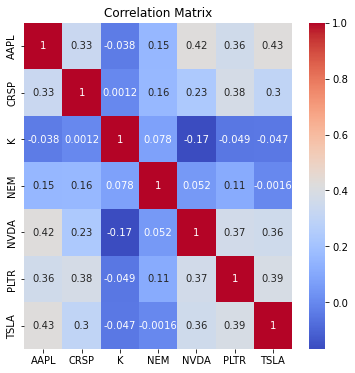

In [57]:
print('Correlation Matrix: ')
display(ef.correlation())

plt.figure(figsize=(6, 6))
sn.heatmap(returns.corr(), annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

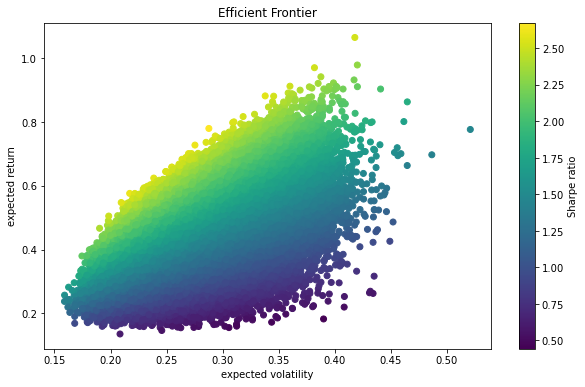

In [58]:
returnCol, volatilityCol, sharpe_ratio, optimal_weights = ef.MonteCarlo()

plt.figure(figsize = (10, 6))
plt.scatter(volatilityCol, returnCol, c = sharpe_ratio, cmap = 'viridis')
plt.title('Efficient Frontier')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')
plt.show()

In [59]:
optimal_weights_table = pd.DataFrame({
    'Asset': stocks,
    'Optimal Weight': optimal_weights
})
print("Optimal Weights for Maximum Sharpe Ratio:")
display(optimal_weights_table.style.hide_index())

Optimal Weights for Maximum Sharpe Ratio:


Asset,Optimal Weight
AAPL,0.067770
TSLA,0.004904
NVDA,0.319450
K,0.033025
CRSP,0.472532
NEM,0.099983
PLTR,0.002335


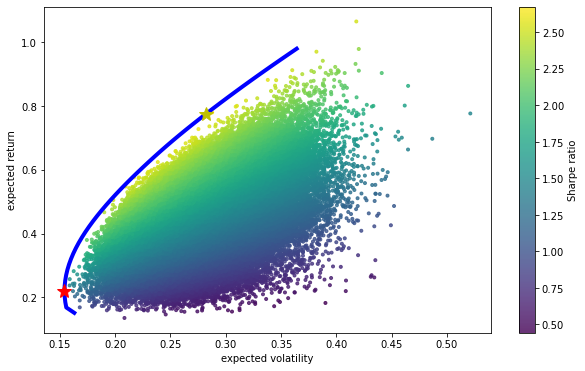

In [60]:
plt.figure(figsize = (10, 6))
plt.scatter(volatilityCol, returnCol, c = sharpe_ratio,marker='.', alpha=0.8, cmap='viridis')
plt.plot(tvolatility, treturns, 'b', lw = 4.0)
plt.plot(ef.PortfolioVolatility(sharpeOptimized['x']), ef.PortfolioReturn(sharpeOptimized['x']),
         'y*', markersize = 15.0)
plt.plot(ef.PortfolioVolatility(volOptimized['x']), ef.PortfolioReturn(volOptimized['x']),
         'r*', markersize = 15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')